In [1]:
import vit
from datasets import Yoga82
from dataset_utils import verify_dataset, calculate_mean_std, load_from_file, get_class_list, get_train
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
print(get_train())

IndexError: list index out of range

In [7]:
'_'.join(['a','b','c'][:-1])

'a_b'

In [2]:
# Setting Config Dict
config = {
    "num_classes": 82,
    "img_size": 128,
    "img_channels": 3,
    "patch_size": 8,
    "hidden_size": 1024,
    "num_hidden_layers": 6,
    "num_attention_heads": 12,
    "mlp_hidden_size": 2048,
    "initializer_range": 0.02,
}
learning_rate = 1e-7
betas = (0.9, 0.999)
weight_decay = 0.3
batch_size = 32
device = 'cuda'
epochs = 300

In [3]:
# Verify Dataset (may take a while :'c)
# images, labels, cls_names = verify_dataset()

In [4]:
images, labels = load_from_file()
cls_names = get_class_list()

Dataset Total: 20107
Total Classes: 82


In [5]:
# Prepare Dataset
X_train, left_images, y_train, left_labels = train_test_split(images, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(left_images, left_labels, test_size=0.5, random_state=42)

#mean, std = calculate_mean_std(X_train)
mean = [0.6692247, 0.64782774, 0.6202068]
std = [0.23499408, 0.23690693, 0.23922563]

print("Mean:", mean)
print("Std:", std)

transform = transforms.Compose([
    transforms.Resize((config['img_size'], config['img_size'])),
    transforms.RandomHorizontalFlip(),
    #transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = Yoga82(X_train, y_train, transform=transform)
val_dataset = Yoga82(X_val, y_val, transform=transform)
test_dataset = Yoga82(X_test, y_test, transform=transform)

Mean: [0.6692247, 0.64782774, 0.6202068]
Std: [0.23499408, 0.23690693, 0.23922563]


In [16]:
# Create a Sampler to Balance Dataset
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data.sampler import WeightedRandomSampler

class_weights = compute_class_weight('balanced', classes=range(82), y=y_train)
class_weights = 1.0  /torch.tensor(class_weights, dtype=torch.float32)
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

#Create model and training parameters
model = vit.ViT(config).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [8]:
checkpoint = torch.load('model_checkpoint_epoch_100.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [28]:
import numpy as np
import torch
import torch.nn as nn
import wandb
from tqdm import tqdm

# Initialize WandB
wandb.init(project='yoga82-vit', name='run')
loss_values = []
avg_loss_values = []
model.train()

# Training loop
for epoch in range(epochs):
    losses_per_epoch = []
    for batch in tqdm(train_dataloader):
        inputs, targets = batch
        inputs, targets = inputs.cuda(), targets.cuda()

        # Your training logic here
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_values.append(loss.item())
        losses_per_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        # Log metrics to WandB
        
    avg_loss = np.mean(losses_per_epoch)
    wandb.log({'epoch': epoch, 'loss': avg_loss.item()})
    avg_loss_values.append(avg_loss)

    # Save the model checkpoint after each epoch
    checkpoint_path = f"model_checkpoint_epoch_{epoch + 1}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }, checkpoint_path)

    print(f"Epoch {epoch + 1} - Loss: {avg_loss.item()} - Model checkpoint saved to {checkpoint_path}")

# Optionally, save the model
wandb.save('your_model.pth')

print("Training completed.")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: felipeandres-valenzuelar (pipper). Use `wandb login --relogin` to force relogin


  0%|          | 0/377 [00:00<?, ?it/s]c:\Users\felip\anaconda3\envs\vit\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 377/377 [07:41<00:00,  1.23s/it]


Epoch 1 - Loss: 4.0637826204932335 - Model checkpoint saved to model_checkpoint_epoch_1.pth


100%|██████████| 377/377 [07:14<00:00,  1.15s/it]


Epoch 2 - Loss: 4.049095940526664 - Model checkpoint saved to model_checkpoint_epoch_2.pth


100%|██████████| 377/377 [07:03<00:00,  1.12s/it]


Epoch 3 - Loss: 4.044875720451618 - Model checkpoint saved to model_checkpoint_epoch_3.pth


100%|██████████| 377/377 [06:49<00:00,  1.09s/it]


Epoch 4 - Loss: 4.03132360746753 - Model checkpoint saved to model_checkpoint_epoch_4.pth


100%|██████████| 377/377 [06:47<00:00,  1.08s/it]


Epoch 5 - Loss: 4.014949972496741 - Model checkpoint saved to model_checkpoint_epoch_5.pth


100%|██████████| 377/377 [06:50<00:00,  1.09s/it]


Epoch 6 - Loss: 4.013726340680919 - Model checkpoint saved to model_checkpoint_epoch_6.pth


100%|██████████| 377/377 [06:48<00:00,  1.08s/it]


Epoch 7 - Loss: 4.001983429455946 - Model checkpoint saved to model_checkpoint_epoch_7.pth


100%|██████████| 377/377 [06:41<00:00,  1.06s/it]


Epoch 8 - Loss: 4.011953317202055 - Model checkpoint saved to model_checkpoint_epoch_8.pth


100%|██████████| 377/377 [06:50<00:00,  1.09s/it]


Epoch 9 - Loss: 3.9967628922955742 - Model checkpoint saved to model_checkpoint_epoch_9.pth


100%|██████████| 377/377 [06:46<00:00,  1.08s/it]


Epoch 10 - Loss: 3.9842611895948252 - Model checkpoint saved to model_checkpoint_epoch_10.pth


100%|██████████| 377/377 [06:46<00:00,  1.08s/it]


Epoch 11 - Loss: 3.9794923108199547 - Model checkpoint saved to model_checkpoint_epoch_11.pth


100%|██████████| 377/377 [06:46<00:00,  1.08s/it]


Epoch 12 - Loss: 3.979949688721715 - Model checkpoint saved to model_checkpoint_epoch_12.pth


100%|██████████| 377/377 [06:48<00:00,  1.08s/it]


Epoch 13 - Loss: 3.967151322478641 - Model checkpoint saved to model_checkpoint_epoch_13.pth


100%|██████████| 377/377 [07:11<00:00,  1.15s/it]


Epoch 14 - Loss: 3.9589503058071793 - Model checkpoint saved to model_checkpoint_epoch_14.pth


100%|██████████| 377/377 [08:49<00:00,  1.40s/it]


Epoch 15 - Loss: 3.9801632693971185 - Model checkpoint saved to model_checkpoint_epoch_15.pth


100%|██████████| 377/377 [06:15<00:00,  1.00it/s]


Epoch 16 - Loss: 3.967179744882356 - Model checkpoint saved to model_checkpoint_epoch_16.pth


100%|██████████| 377/377 [06:09<00:00,  1.02it/s]


Epoch 17 - Loss: 3.950787954684594 - Model checkpoint saved to model_checkpoint_epoch_17.pth


100%|██████████| 377/377 [06:10<00:00,  1.02it/s]


Epoch 18 - Loss: 3.9563421728756447 - Model checkpoint saved to model_checkpoint_epoch_18.pth


100%|██████████| 377/377 [06:07<00:00,  1.02it/s]


Epoch 19 - Loss: 3.9513530433968462 - Model checkpoint saved to model_checkpoint_epoch_19.pth


100%|██████████| 377/377 [06:11<00:00,  1.01it/s]


Epoch 20 - Loss: 3.9543216955756635 - Model checkpoint saved to model_checkpoint_epoch_20.pth


100%|██████████| 377/377 [06:10<00:00,  1.02it/s]


Epoch 21 - Loss: 3.9492552539714136 - Model checkpoint saved to model_checkpoint_epoch_21.pth


100%|██████████| 377/377 [06:11<00:00,  1.01it/s]


Epoch 22 - Loss: 3.950259127730716 - Model checkpoint saved to model_checkpoint_epoch_22.pth


100%|██████████| 377/377 [06:19<00:00,  1.01s/it]


Epoch 23 - Loss: 3.943462799967758 - Model checkpoint saved to model_checkpoint_epoch_23.pth


100%|██████████| 377/377 [06:18<00:00,  1.00s/it]


Epoch 24 - Loss: 3.9503341031011283 - Model checkpoint saved to model_checkpoint_epoch_24.pth


100%|██████████| 377/377 [06:13<00:00,  1.01it/s]


Epoch 25 - Loss: 3.9452830676374764 - Model checkpoint saved to model_checkpoint_epoch_25.pth


100%|██████████| 377/377 [06:19<00:00,  1.01s/it]


Epoch 26 - Loss: 3.9390661646896077 - Model checkpoint saved to model_checkpoint_epoch_26.pth


100%|██████████| 377/377 [06:13<00:00,  1.01it/s]


Epoch 27 - Loss: 3.9388831989834734 - Model checkpoint saved to model_checkpoint_epoch_27.pth


100%|██████████| 377/377 [06:11<00:00,  1.02it/s]


Epoch 28 - Loss: 3.936081364553234 - Model checkpoint saved to model_checkpoint_epoch_28.pth


100%|██████████| 377/377 [06:13<00:00,  1.01it/s]


Epoch 29 - Loss: 3.923827494487206 - Model checkpoint saved to model_checkpoint_epoch_29.pth


100%|██████████| 377/377 [06:14<00:00,  1.01it/s]


Epoch 30 - Loss: 3.936113273433412 - Model checkpoint saved to model_checkpoint_epoch_30.pth


100%|██████████| 377/377 [06:12<00:00,  1.01it/s]


Epoch 31 - Loss: 3.919974351751393 - Model checkpoint saved to model_checkpoint_epoch_31.pth


100%|██████████| 377/377 [06:07<00:00,  1.02it/s]


Epoch 32 - Loss: 3.928611571339777 - Model checkpoint saved to model_checkpoint_epoch_32.pth


100%|██████████| 377/377 [06:07<00:00,  1.02it/s]


Epoch 33 - Loss: 3.9471063651836205 - Model checkpoint saved to model_checkpoint_epoch_33.pth


100%|██████████| 377/377 [06:11<00:00,  1.01it/s]


Epoch 34 - Loss: 3.9484114558374217 - Model checkpoint saved to model_checkpoint_epoch_34.pth


100%|██████████| 377/377 [06:13<00:00,  1.01it/s]


Epoch 35 - Loss: 3.927598980440701 - Model checkpoint saved to model_checkpoint_epoch_35.pth


100%|██████████| 377/377 [06:07<00:00,  1.03it/s]


Epoch 36 - Loss: 3.9367188623160203 - Model checkpoint saved to model_checkpoint_epoch_36.pth


100%|██████████| 377/377 [06:07<00:00,  1.03it/s]


Epoch 37 - Loss: 3.9407793944331 - Model checkpoint saved to model_checkpoint_epoch_37.pth


100%|██████████| 377/377 [06:12<00:00,  1.01it/s]


Epoch 38 - Loss: 3.939873069287611 - Model checkpoint saved to model_checkpoint_epoch_38.pth


100%|██████████| 377/377 [06:16<00:00,  1.00it/s]


Epoch 39 - Loss: 3.929805931425221 - Model checkpoint saved to model_checkpoint_epoch_39.pth


100%|██████████| 377/377 [06:13<00:00,  1.01it/s]


Epoch 40 - Loss: 3.928291657875324 - Model checkpoint saved to model_checkpoint_epoch_40.pth


100%|██████████| 377/377 [06:13<00:00,  1.01it/s]


Epoch 41 - Loss: 3.9362522505954973 - Model checkpoint saved to model_checkpoint_epoch_41.pth


100%|██████████| 377/377 [06:07<00:00,  1.03it/s]


Epoch 42 - Loss: 3.928790337210941 - Model checkpoint saved to model_checkpoint_epoch_42.pth


100%|██████████| 377/377 [06:11<00:00,  1.01it/s]


Epoch 43 - Loss: 3.9295115300135524 - Model checkpoint saved to model_checkpoint_epoch_43.pth


100%|██████████| 377/377 [06:12<00:00,  1.01it/s]


Epoch 44 - Loss: 3.9178720279460877 - Model checkpoint saved to model_checkpoint_epoch_44.pth


100%|██████████| 377/377 [06:09<00:00,  1.02it/s]


Epoch 45 - Loss: 3.927833896100679 - Model checkpoint saved to model_checkpoint_epoch_45.pth


100%|██████████| 377/377 [06:09<00:00,  1.02it/s]


Epoch 46 - Loss: 3.927757193618491 - Model checkpoint saved to model_checkpoint_epoch_46.pth


100%|██████████| 377/377 [06:06<00:00,  1.03it/s]


Epoch 47 - Loss: 3.923052983195459 - Model checkpoint saved to model_checkpoint_epoch_47.pth


100%|██████████| 377/377 [07:02<00:00,  1.12s/it]


Epoch 48 - Loss: 3.922917704367195 - Model checkpoint saved to model_checkpoint_epoch_48.pth


100%|██████████| 377/377 [06:30<00:00,  1.04s/it]


Epoch 49 - Loss: 3.932696429740845 - Model checkpoint saved to model_checkpoint_epoch_49.pth


100%|██████████| 377/377 [06:21<00:00,  1.01s/it]


Epoch 50 - Loss: 3.921357939034621 - Model checkpoint saved to model_checkpoint_epoch_50.pth


100%|██████████| 377/377 [06:17<00:00,  1.00s/it]


Epoch 51 - Loss: 3.9259362657127075 - Model checkpoint saved to model_checkpoint_epoch_51.pth


100%|██████████| 377/377 [06:11<00:00,  1.01it/s]


Epoch 52 - Loss: 3.9186406508680998 - Model checkpoint saved to model_checkpoint_epoch_52.pth


100%|██████████| 377/377 [06:12<00:00,  1.01it/s]


Epoch 53 - Loss: 3.915716393240567 - Model checkpoint saved to model_checkpoint_epoch_53.pth


100%|██████████| 377/377 [06:10<00:00,  1.02it/s]


Epoch 54 - Loss: 3.9231494908623734 - Model checkpoint saved to model_checkpoint_epoch_54.pth


100%|██████████| 377/377 [06:12<00:00,  1.01it/s]


Epoch 55 - Loss: 3.897686821080013 - Model checkpoint saved to model_checkpoint_epoch_55.pth


100%|██████████| 377/377 [06:20<00:00,  1.01s/it]


Epoch 56 - Loss: 3.9210056872835843 - Model checkpoint saved to model_checkpoint_epoch_56.pth


100%|██████████| 377/377 [06:14<00:00,  1.01it/s]


Epoch 57 - Loss: 3.917601884518125 - Model checkpoint saved to model_checkpoint_epoch_57.pth


100%|██████████| 377/377 [06:13<00:00,  1.01it/s]


Epoch 58 - Loss: 3.9043428537383953 - Model checkpoint saved to model_checkpoint_epoch_58.pth


100%|██████████| 377/377 [06:19<00:00,  1.01s/it]


Epoch 59 - Loss: 3.911111671032893 - Model checkpoint saved to model_checkpoint_epoch_59.pth


100%|██████████| 377/377 [06:10<00:00,  1.02it/s]


Epoch 60 - Loss: 3.917878002955996 - Model checkpoint saved to model_checkpoint_epoch_60.pth


100%|██████████| 377/377 [06:11<00:00,  1.01it/s]


Epoch 61 - Loss: 3.907804387317728 - Model checkpoint saved to model_checkpoint_epoch_61.pth


100%|██████████| 377/377 [06:16<00:00,  1.00it/s]


Epoch 62 - Loss: 3.9274618543427566 - Model checkpoint saved to model_checkpoint_epoch_62.pth


100%|██████████| 377/377 [06:16<00:00,  1.00it/s]


Epoch 63 - Loss: 3.908813293163593 - Model checkpoint saved to model_checkpoint_epoch_63.pth


100%|██████████| 377/377 [06:10<00:00,  1.02it/s]


Epoch 64 - Loss: 3.9275485653459867 - Model checkpoint saved to model_checkpoint_epoch_64.pth


100%|██████████| 377/377 [06:14<00:00,  1.01it/s]


Epoch 65 - Loss: 3.9141998721054443 - Model checkpoint saved to model_checkpoint_epoch_65.pth


100%|██████████| 377/377 [06:09<00:00,  1.02it/s]


Epoch 66 - Loss: 3.9177858658747584 - Model checkpoint saved to model_checkpoint_epoch_66.pth


100%|██████████| 377/377 [06:09<00:00,  1.02it/s]


Epoch 67 - Loss: 3.918791670381865 - Model checkpoint saved to model_checkpoint_epoch_67.pth


100%|██████████| 377/377 [06:11<00:00,  1.01it/s]


Epoch 68 - Loss: 3.921994376878207 - Model checkpoint saved to model_checkpoint_epoch_68.pth


100%|██████████| 377/377 [06:12<00:00,  1.01it/s]


Epoch 69 - Loss: 3.927389522446245 - Model checkpoint saved to model_checkpoint_epoch_69.pth


100%|██████████| 377/377 [06:17<00:00,  1.00s/it]


Epoch 70 - Loss: 3.911422188149207 - Model checkpoint saved to model_checkpoint_epoch_70.pth


100%|██████████| 377/377 [06:12<00:00,  1.01it/s]


Epoch 71 - Loss: 3.914878463239189 - Model checkpoint saved to model_checkpoint_epoch_71.pth


100%|██████████| 377/377 [06:13<00:00,  1.01it/s]


Epoch 72 - Loss: 3.917790496380955 - Model checkpoint saved to model_checkpoint_epoch_72.pth


100%|██████████| 377/377 [06:13<00:00,  1.01it/s]


Epoch 73 - Loss: 3.911776899975238 - Model checkpoint saved to model_checkpoint_epoch_73.pth


100%|██████████| 377/377 [06:29<00:00,  1.03s/it]


Epoch 74 - Loss: 3.917237068044728 - Model checkpoint saved to model_checkpoint_epoch_74.pth


100%|██████████| 377/377 [19:04<00:00,  3.04s/it]


Epoch 75 - Loss: 3.89828477993568 - Model checkpoint saved to model_checkpoint_epoch_75.pth


100%|██████████| 377/377 [10:44<00:00,  1.71s/it]


Epoch 76 - Loss: 3.903858120941041 - Model checkpoint saved to model_checkpoint_epoch_76.pth


100%|██████████| 377/377 [06:24<00:00,  1.02s/it]


Epoch 77 - Loss: 3.8955494054748776 - Model checkpoint saved to model_checkpoint_epoch_77.pth


100%|██████████| 377/377 [06:22<00:00,  1.02s/it]


Epoch 78 - Loss: 3.9133728088055113 - Model checkpoint saved to model_checkpoint_epoch_78.pth


100%|██████████| 377/377 [06:29<00:00,  1.03s/it]


Epoch 79 - Loss: 3.925160816556895 - Model checkpoint saved to model_checkpoint_epoch_79.pth


100%|██████████| 377/377 [06:30<00:00,  1.04s/it]


Epoch 80 - Loss: 3.9140228725554773 - Model checkpoint saved to model_checkpoint_epoch_80.pth


100%|██████████| 377/377 [06:24<00:00,  1.02s/it]


Epoch 81 - Loss: 3.9080591992294758 - Model checkpoint saved to model_checkpoint_epoch_81.pth


100%|██████████| 377/377 [06:23<00:00,  1.02s/it]


Epoch 82 - Loss: 3.9159767362103852 - Model checkpoint saved to model_checkpoint_epoch_82.pth


100%|██████████| 377/377 [06:27<00:00,  1.03s/it]


Epoch 83 - Loss: 3.9158983104108818 - Model checkpoint saved to model_checkpoint_epoch_83.pth


100%|██████████| 377/377 [06:24<00:00,  1.02s/it]


Epoch 84 - Loss: 3.9066866892402303 - Model checkpoint saved to model_checkpoint_epoch_84.pth


100%|██████████| 377/377 [06:26<00:00,  1.03s/it]


Epoch 85 - Loss: 3.926772062595074 - Model checkpoint saved to model_checkpoint_epoch_85.pth


100%|██████████| 377/377 [06:28<00:00,  1.03s/it]


Epoch 86 - Loss: 3.909458721348082 - Model checkpoint saved to model_checkpoint_epoch_86.pth


100%|██████████| 377/377 [06:25<00:00,  1.02s/it]


Epoch 87 - Loss: 3.917340794672068 - Model checkpoint saved to model_checkpoint_epoch_87.pth


100%|██████████| 377/377 [06:19<00:00,  1.01s/it]


Epoch 88 - Loss: 3.9174159079078654 - Model checkpoint saved to model_checkpoint_epoch_88.pth


100%|██████████| 377/377 [06:24<00:00,  1.02s/it]


Epoch 89 - Loss: 3.9081939942640713 - Model checkpoint saved to model_checkpoint_epoch_89.pth


100%|██████████| 377/377 [06:24<00:00,  1.02s/it]


Epoch 90 - Loss: 3.9186805407627823 - Model checkpoint saved to model_checkpoint_epoch_90.pth


100%|██████████| 377/377 [06:27<00:00,  1.03s/it]


Epoch 91 - Loss: 3.919269662320772 - Model checkpoint saved to model_checkpoint_epoch_91.pth


100%|██████████| 377/377 [06:20<00:00,  1.01s/it]


Epoch 92 - Loss: 3.916119025303767 - Model checkpoint saved to model_checkpoint_epoch_92.pth


100%|██████████| 377/377 [06:24<00:00,  1.02s/it]


Epoch 93 - Loss: 3.9058088004114775 - Model checkpoint saved to model_checkpoint_epoch_93.pth


100%|██████████| 377/377 [06:22<00:00,  1.02s/it]


Epoch 94 - Loss: 3.9058384288211085 - Model checkpoint saved to model_checkpoint_epoch_94.pth


100%|██████████| 377/377 [06:23<00:00,  1.02s/it]


Epoch 95 - Loss: 3.9203433484550496 - Model checkpoint saved to model_checkpoint_epoch_95.pth


100%|██████████| 377/377 [06:29<00:00,  1.03s/it]


Epoch 96 - Loss: 3.9116930367143463 - Model checkpoint saved to model_checkpoint_epoch_96.pth


100%|██████████| 377/377 [06:27<00:00,  1.03s/it]


Epoch 97 - Loss: 3.912018762659331 - Model checkpoint saved to model_checkpoint_epoch_97.pth


100%|██████████| 377/377 [06:20<00:00,  1.01s/it]


Epoch 98 - Loss: 3.92185142754876 - Model checkpoint saved to model_checkpoint_epoch_98.pth


100%|██████████| 377/377 [06:25<00:00,  1.02s/it]


Epoch 99 - Loss: 3.9063439356553458 - Model checkpoint saved to model_checkpoint_epoch_99.pth


100%|██████████| 377/377 [06:26<00:00,  1.03s/it]


Epoch 100 - Loss: 3.9253330420435897 - Model checkpoint saved to model_checkpoint_epoch_100.pth


100%|██████████| 377/377 [06:26<00:00,  1.02s/it]


Epoch 101 - Loss: 3.8921595454532207 - Model checkpoint saved to model_checkpoint_epoch_101.pth


100%|██████████| 377/377 [06:46<00:00,  1.08s/it]


Epoch 102 - Loss: 3.929775671870386 - Model checkpoint saved to model_checkpoint_epoch_102.pth


  2%|▏         | 8/377 [00:16<13:02,  2.12s/it]


KeyboardInterrupt: 

In [8]:
checkpoint = {
    'model_state_dict': model.state_dict(),
}
torch.save(checkpoint, f'base_checkpoint.pth')

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
from tqdm import tqdm
# Acc. and Conf. Matriz function
def model_analysis(model,dataloader,device='cuda',model_name='',dataset_name='Validation Dataset',conf_matrix=True,cmap="rainbow",figsize=25):
  model.eval()
  y_batch_pred=[]
  y_batch_true=[]
  with torch.no_grad():
    for data in tqdm(dataloader):
      inputs = data[0].to(device)
      labels = data[1].to(device)
      outputs = model(inputs)
      #Compute accuracy
      smax = nn.LogSoftmax(dim=1)
      pred = torch.argmax(smax(outputs),dim=1)
      y_batch_pred.append(pred.tolist())
      y_batch_true.append(labels.tolist())
  y_pred = np.concatenate(y_batch_pred)
  y_true = np.concatenate(y_batch_true)
  acc = metrics.accuracy_score(y_true,y_pred,normalize=True)
  if dataset_name!=None:
    print('\n{} Accuracy for {}: {}'.format(model_name,dataset_name,acc))
  else:
    print('\n{} Accuracy: {}'.format(model_name,acc))

  #Confusion Matrix Plot
  if conf_matrix:
    conf_mat = metrics.confusion_matrix(y_true,y_pred,normalize='true')
    plt.figure(figsize=(figsize,figsize))
    cfm_plot = sns.heatmap(conf_mat,cmap=cmap,annot=True)
    if dataset_name!=None:
      plt.title('{} \n Confusion Matrix for {}'.format(model_name,dataset_name))
    else:
      plt.title('{} \n Confusion Matrix'.format(model_name))

  return acc

  0%|          | 0/377 [00:00<?, ?it/s]c:\Users\felip\anaconda3\envs\vit\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 377/377 [04:32<00:00,  1.38it/s]



 Accuracy for Validation Dataset: 0.00605106100795756


0.00605106100795756

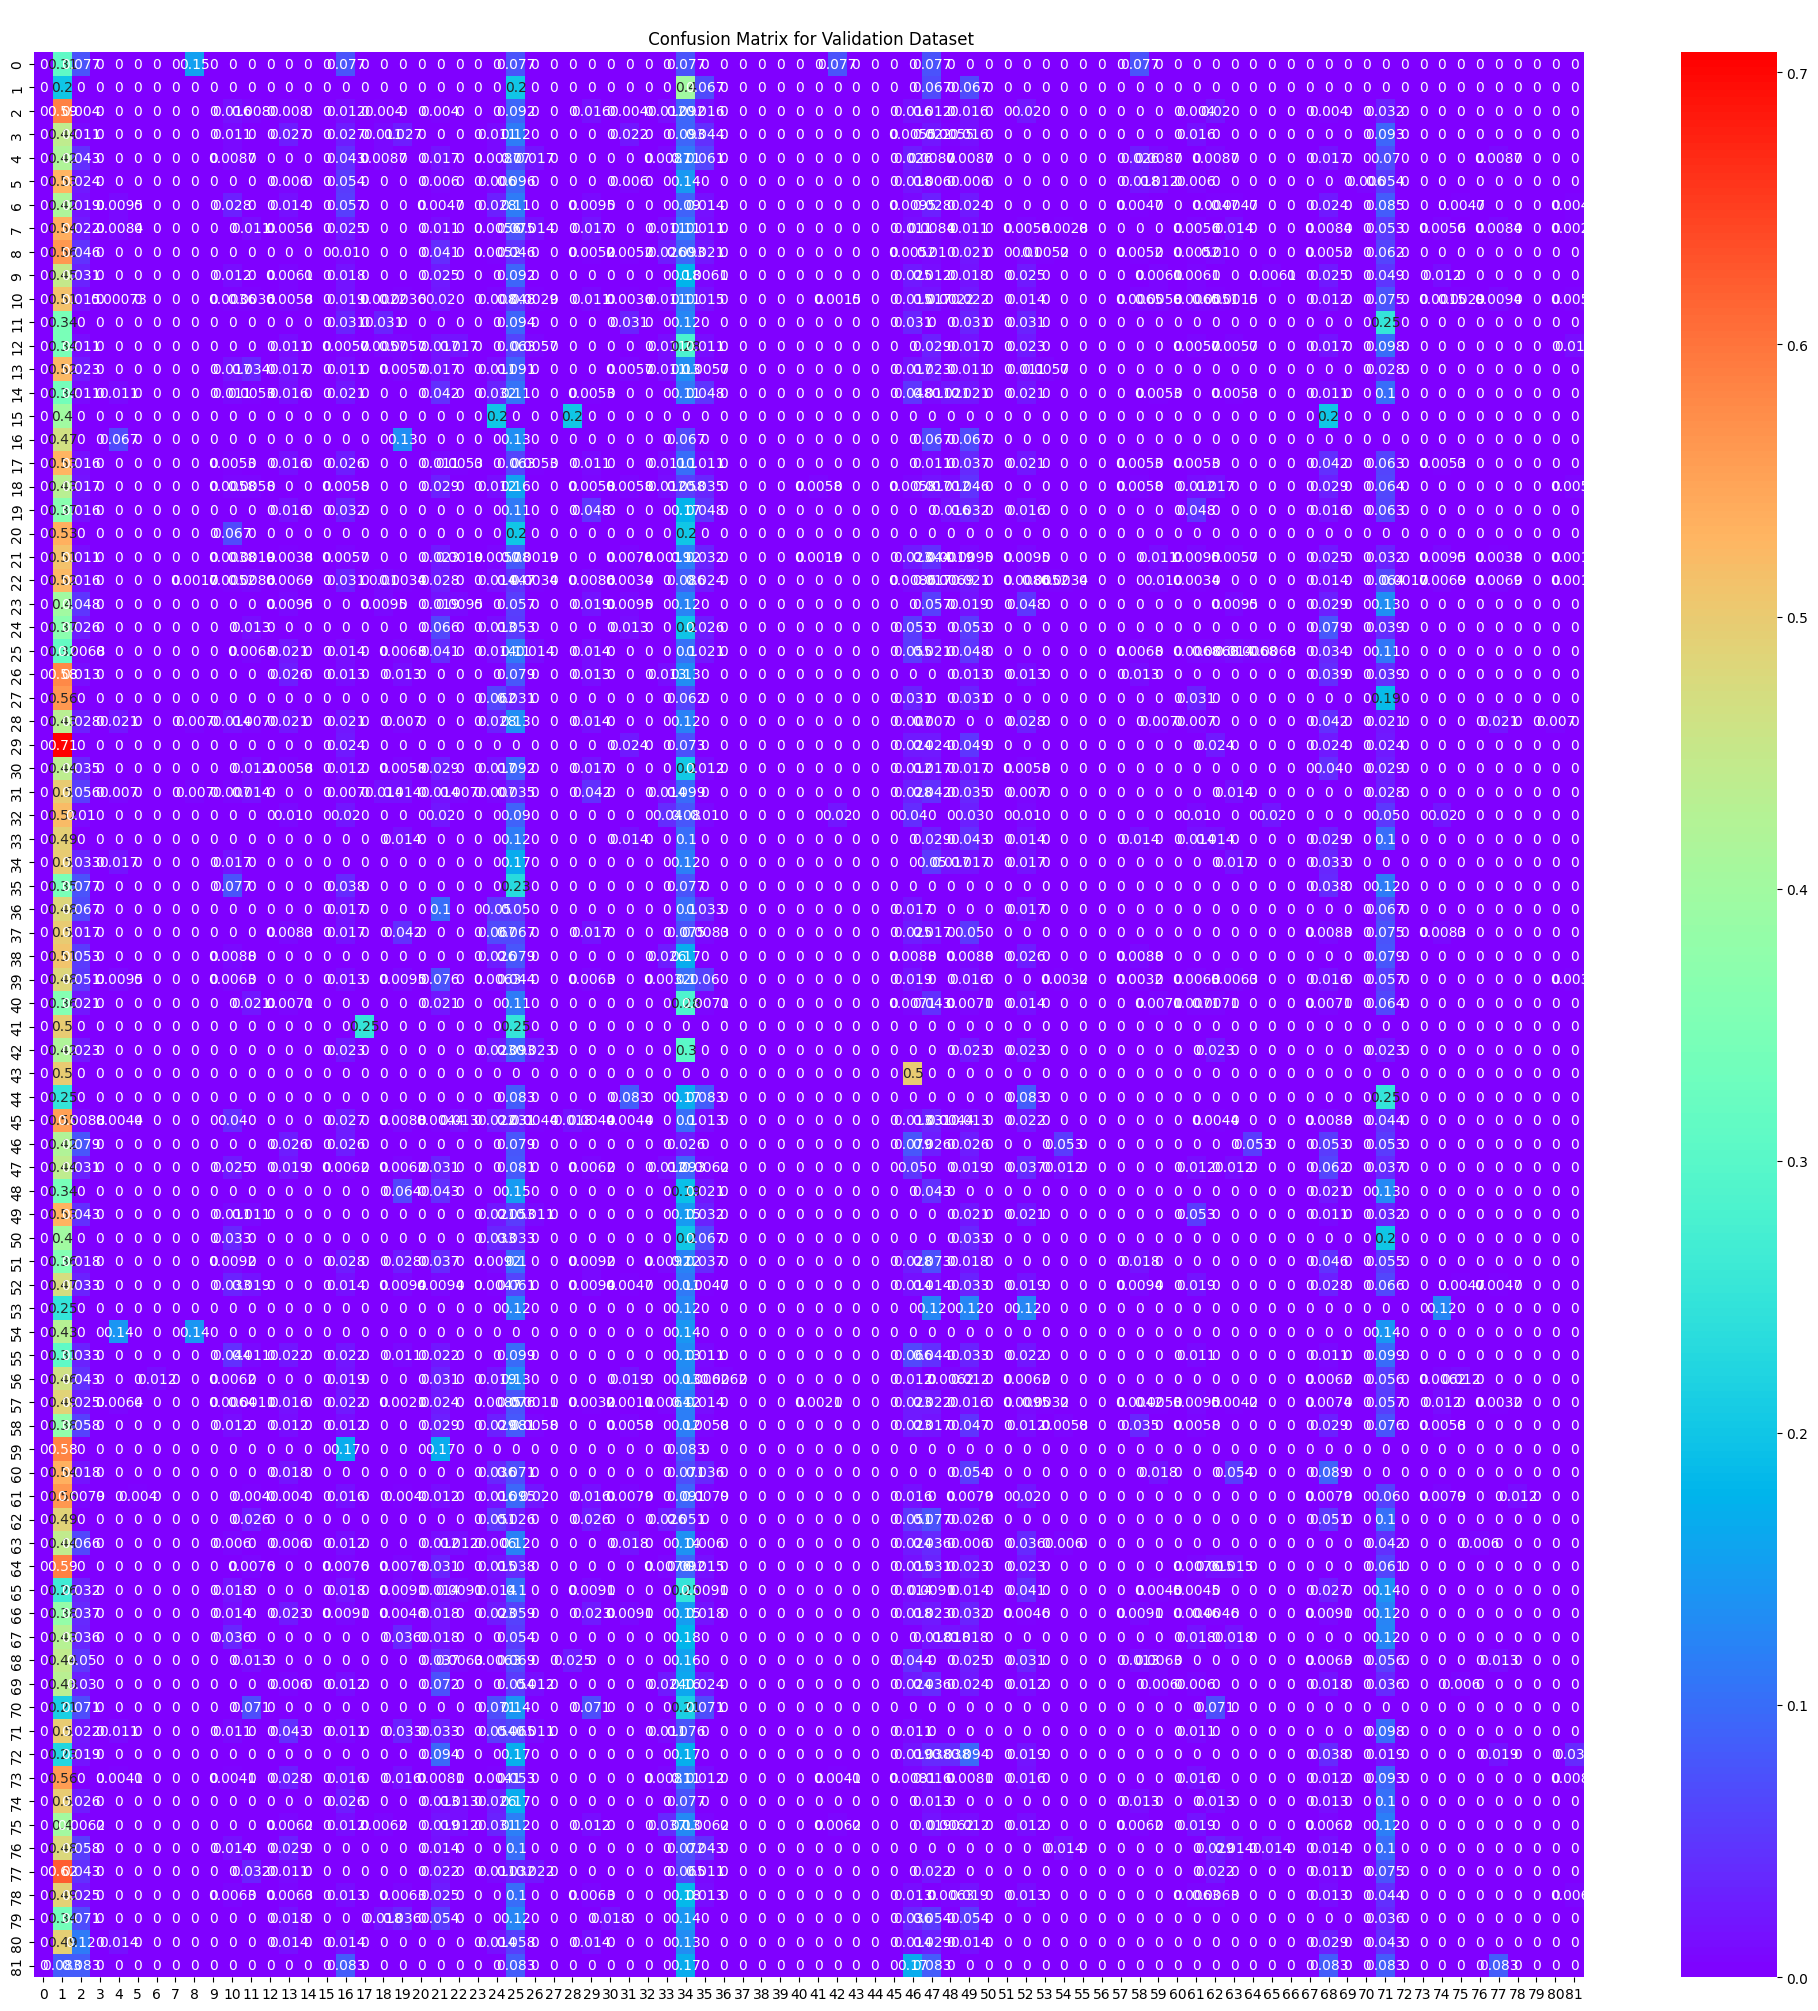

In [19]:
model_analysis(model, train_dataloader)

In [ ]:
plt.figure(figsize=(12,12))
plt.show()

<Figure size 1200x1200 with 0 Axes>